In [8]:
import numpy as np 
import pandas as pd
import parameters as pa
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras import layers
tf.executing_eagerly()

# Just disables the warning, doesn't enable AVX/FMA
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

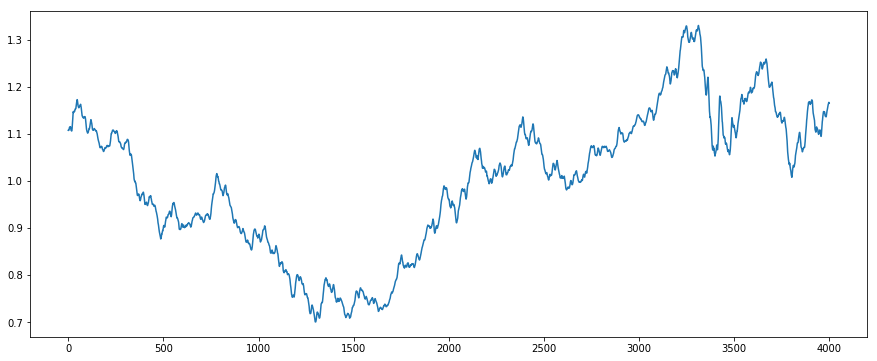

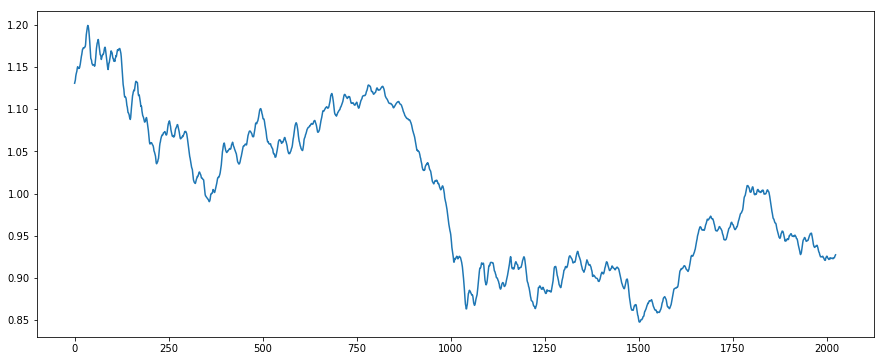

In [9]:
data = np.array(pd.read_csv(pa.FILE_NAME).values[:, pa.OHLC], dtype="f")

def plot_data(data):
    plt.figure(figsize=(15,6))
    plt.plot(data)

weights = np.exp(np.linspace(-1., 0., 8))
weights /= weights.sum()
exp =  np.convolve(data, weights, mode='full')[:len(data)]
exp[:8] = exp[8]
data = exp

# train from 1995.08.23 to 2011.03.15
mean_train = np.mean(data[6000:10000])
mean_test = np.mean(data[10000:])
train_data = data[6000:10000]/mean_train
test_data = data[10000:]/mean_test

plot_data(train_data)
plot_data(test_data)

In [10]:
tf_train = tf.data.Dataset.from_tensor_slices(train_data).window(size=6, shift=1, drop_remainder=True).flat_map(
        lambda x: x.batch(6))

data = tf_train.map(lambda x: tf.reshape(x[:5],[5,1]))
labels = tf_train.map(lambda x: x[-1:])

dataset = tf.data.Dataset.zip((data,labels)).batch(1)

# fucntional Model
inputs = tf.keras.Input(batch_shape=(1, None, 1))
x = tf.keras.layers.LSTM(128, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')(inputs)
x1 = tf.keras.layers.LSTM(128, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')(x) 
x2 = tf.keras.layers.LSTM(128, return_sequences=False, recurrent_initializer='glorot_uniform')(x1+x)
outputs = tf.keras.layers.Dense(1)(x2)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name="LSTM Model")
model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(0.01),loss='mse',metrics=['MAE','MAPE']) 

callbacks = [tf.keras.callbacks.EarlyStopping(patience=1, monitor='MAPE')]

model.fit(dataset, epochs=25, callbacks=callbacks, verbose=1)

Model: "LSTM Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(1, None, 1)]       0                                            
__________________________________________________________________________________________________
unified_lstm_8 (UnifiedLSTM)    (1, None, 128)       66560       input_4[0][0]                    
__________________________________________________________________________________________________
unified_lstm_9 (UnifiedLSTM)    (1, None, 128)       131584      unified_lstm_8[0][0]             
__________________________________________________________________________________________________
add_2 (TensorFlowOpLayer)       [(1, None, 128)]     0           unified_lstm_9[0][0]             
                                                                 unified_lstm_8[0][0]    

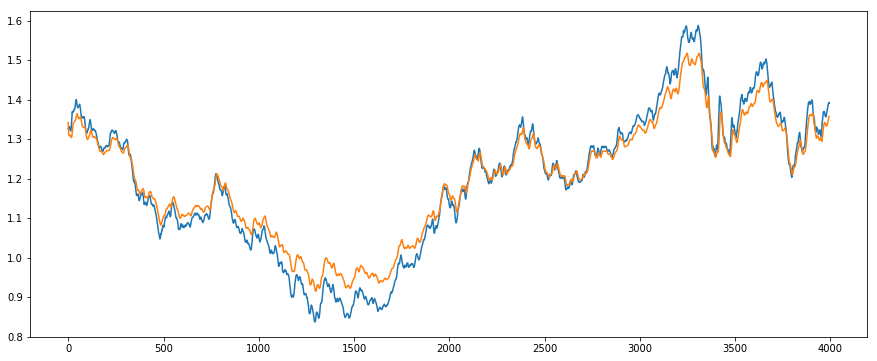

In [11]:
pred = model.predict(data.batch(1))

plt.figure(figsize=(15,6))
plt.plot(train_data[5:3995+5]*mean_train)
plt.plot((pred*np.mean(pred,axis =1)[:,None]).reshape(3995))

   2019/Unknown - 14s 7ms/step - loss: 0.0116 - MAE: 0.0952 - MAPE: 10.0614

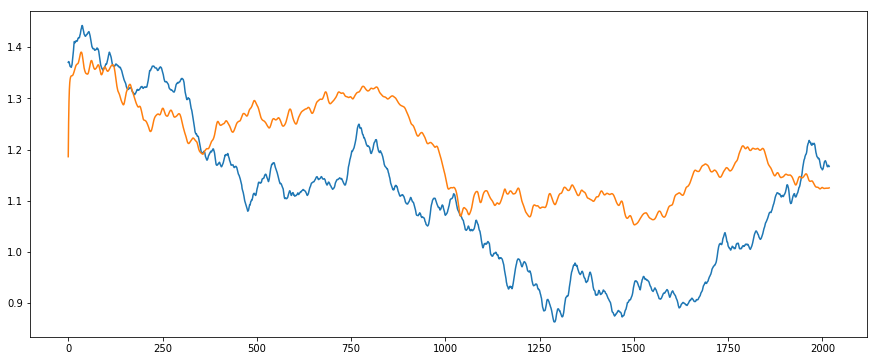

In [12]:
tf_test = tf.data.Dataset.from_tensor_slices(test_data).window(size=6, shift=1, drop_remainder=True).flat_map(
        lambda x: x.batch(6))

testd = tf_test.map(lambda x: tf.reshape(x[:5],[5,1]))
testl = tf_test.map(lambda x: x[-1:])

model.evaluate(tf.data.Dataset.zip((testd,testl)).batch(1))

pred = model.predict(testd.batch(1))
plt.figure(figsize=(15,6))
plt.plot(train_data[10:2019+10]*mean_test)
plt.plot((pred*np.mean(pred,axis =1)[:,None]).reshape(2019))